In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [11]:
# Load the training data
providence_file_path = '../../Data/Clean/combined/Providence_combined.csv'
train_full_df = pd.read_csv(providence_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,279826.0,1094.0,268863782.0,275076.989042,286193.357806,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,578.1,-0.9,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
1,2008-05-31,287299.0,1278.0,324116899.0,274598.055307,283995.275711,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,576.2,-1.3,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
2,2008-06-30,291347.0,1439.0,371228964.0,274776.048804,281705.331555,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,574.6,-1.6,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
3,2008-07-31,294474.0,1368.0,401046568.0,273315.038401,279020.136289,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,572.9,-1.7,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"
4,2008-08-31,292317.0,1240.0,394628893.0,271264.245006,275929.894315,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,570.9,-1.8,5757.78597,93.596408,46.976027,"PROVIDENCE, RI"


In [12]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [13]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [14]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"PROVIDENCE, RI",1,0,0.0,"Index(['PROVIDENCE, RI'], dtype='object', name..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,5757.78597,1,0,0.0,"Index([5757.78597], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,93.596408,1,0,0.0,"Index([93.596408], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,46.976027,1,0,0.0,"Index([46.976027], dtype='float64', name='PctB..."


In [15]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [16]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [17]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [18]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [20]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.229470,0.221972,0.998873,0.746262,0.286152,0.281699,0.222118,0.072561
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.380998,0.361124,1.063517,0.768082,0.331372,0.331878,0.361508,0.352787


Note for Providence dataset
* HistGradientBoost best performance across varied transformations, especially StandardScaler
* Consistent poor performance of Lasso Regression 

In [21]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.218801,0.214924,0.942094,0.689043,0.214420,0.211267,0.215655,0.076415
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.428158,0.345579,0.816420,0.525777,0.333882,0.340396,0.345579,0.275771


Note for Providence dataset
* HistGradientBoost and Lasso Regression with the StandardScaler has best performance
* Lasso significantly better, especially under QuantileTransformer

In [22]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [23]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You mig

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.298324,0.294461,0.998873,0.909247,0.559450,0.559455,0.295615,0.174204
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.497097,0.486524,1.096370,0.951832,0.485858,0.484323,0.490052,0.440039


Note:
* HistGradientBoost with the best result
* Lasso Regression consistent poor performance, regularization may be too high

In [25]:
# Evaluate RMSE for various regression models and target transformations with all ordinally encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You mig

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.326439,0.331774,0.942094,0.847946,0.333462,0.335530,0.331774,0.173477
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.367588,0.353074,0.888282,0.717947,0.339435,0.340038,0.353074,0.303744


Note:
* HistGradientBoost still has the best result, made even better than the last

## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [26]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [27]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"PROVIDENCE, RI",1,0,0.0,"Index(['PROVIDENCE, RI'], dtype='object', name..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,5757.78597,1,0,0.0,"Index([5757.78597], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,93.596408,1,0,0.0,"Index([93.596408], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,46.976027,1,0,0.0,"Index([46.976027], dtype='float64', name='PctB..."


In [28]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [29]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 0.0001 (R^2 score:  0.99)


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.990722,6.655641e-12,0.557837,1.721979e+01,0.105043,0.052524,1.148289
numerical__TotalTransactionValue,0.789217,1.088978e-12,0.786872,2.393573e+01,0.122558,0.190611,1.102386
numerical__NewConstructMeanSalePrice,0.277095,1.496505e-13,0.870718,3.876052e+00,0.248448,0.281712,0.807256
numerical__MORTGAGE30US,0.233502,2.291595e-11,0.999631,6.310042e+06,0.073132,0.496145,0.802780
numerical__MORTGAGE15US,0.232953,2.328814e-11,0.999721,6.601051e+06,0.056759,0.491313,0.781024


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: num must be an integer with 1 <= num <= 12, not 13

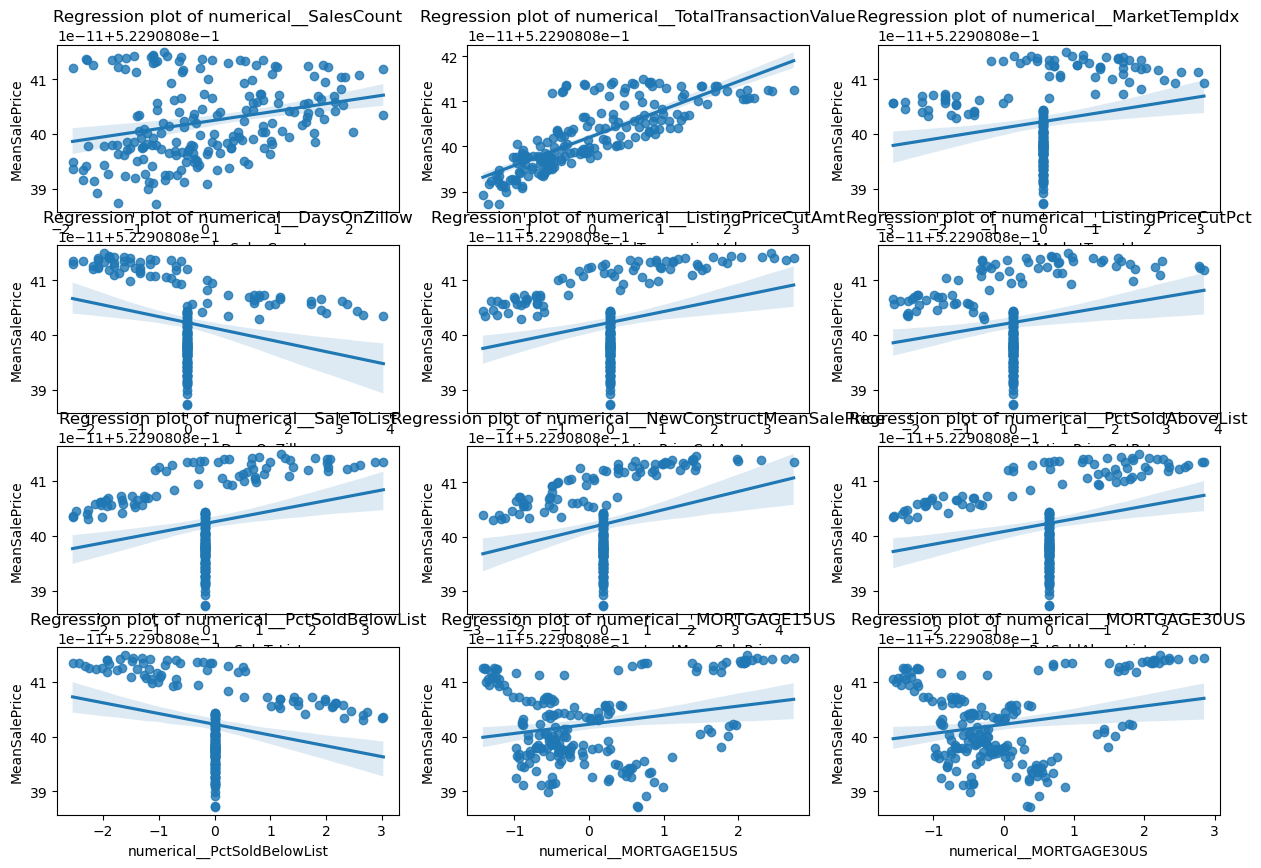

In [32]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.1)

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


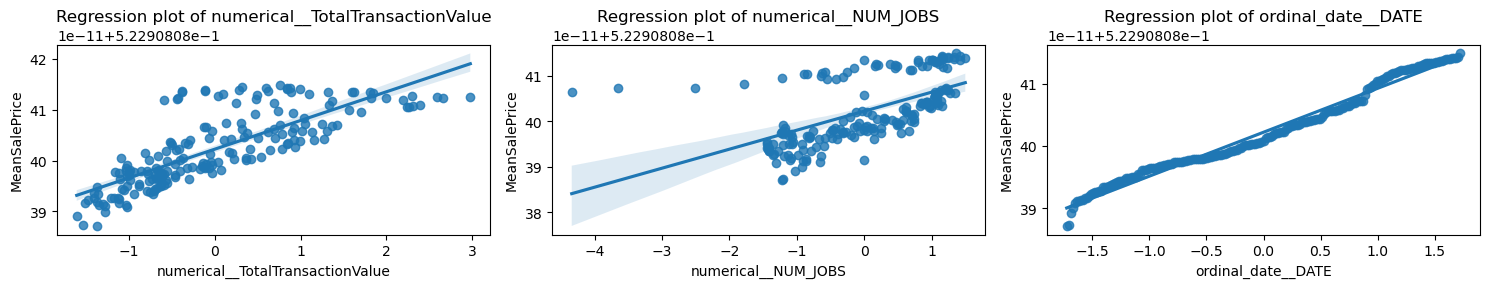

In [33]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.5)

## Perform unsupervised feature selection

Optimal number of features: 6


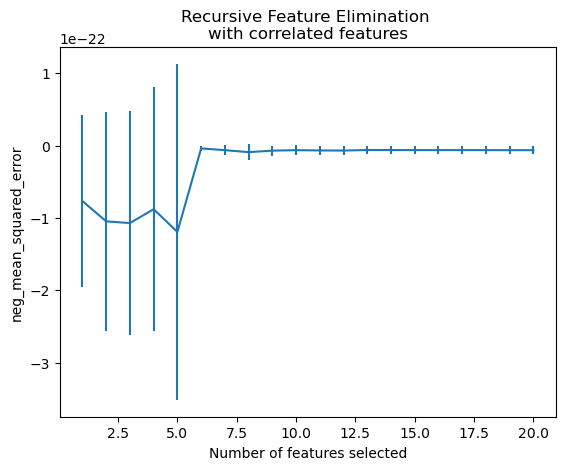

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-7.669664e-23,1.189555e-22,-1.308714e-24,-1.082090e-24,-1.384611e-24,-7.138418e-23,-3.083236e-22,True,1,SalesCount
1,-1.046556e-22,1.517098e-22,-1.307619e-24,-1.159230e-24,-1.516649e-24,-1.273509e-22,-3.919435e-22,True,1,TotalTransactionValue
2,-1.070345e-22,1.542314e-22,-1.579761e-24,-8.652333e-25,-1.917384e-24,-1.324917e-22,-3.983183e-22,False,4,MarketTempIdx
3,-8.786939e-23,1.687968e-22,-1.580491e-24,-8.656007e-25,-1.917800e-24,-4.254037e-22,-9.579383e-24,False,13,DaysToClose
4,-1.192661e-22,2.321663e-22,-1.403706e-24,-9.269392e-25,-1.970542e-24,-5.835663e-22,-8.462999e-24,False,2,DaysOnZillow


In [34]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [35]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['SalesCount' 'TotalTransactionValue' 'MORTGAGE15US' 'MORTGAGE30US'
 'RATE_DIFFERENCE' 'DATE']


Optimal number of features: 3


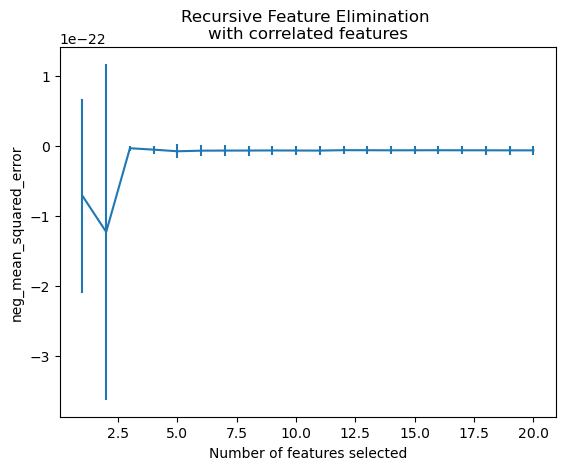

In [36]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=7))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [37]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['TotalTransactionValue' 'MORTGAGE30US' 'DATE']


In [38]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 10 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=6)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 0.001
Selected 6 features by forward sequential featureselection in 0.758 seconds
SFS Ridge Selected Features: ['SalesCount', 'DaysToClose', 'PctSoldAboveList', 'RATE_DIFFERENCE', 'DATE', 'CityName']


In [39]:
# # Remove colinear features from the list of selected features
# # rfe_ridge_selected_features = [rfe_ridge_selected_features]
# rfe_ridge_selected_features = list(rfe_ridge_selected_features).remove('PctListingsPriceCut')
# rfe_ridge_selected_features

In [39]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(1, ['DATE'])

## Perform final EDA with selected features and ordinal columns

In [40]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=array(['TotalTransactionValue', 'MORTGAGE30US', 'DATE'], dtype=object))),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['SalesCount', 'TotalTr...
                                                                              '2011-03-31',
                                                                              '2013-04-30',
                                                                              '2010-04-30',
                                                                              '2011-05-31',
                                                                              '2012-01-31',
                                                                              '2010-03-31',
                                                                              '2009-07-31',
                                                                              '2010-05-31',
                                                                              '2010-02-28',
                                                                              '2009-01-31',
                                                                              '2012-06-30',
                                                                              '2009-11-30',
                                                                              '2009-12-31',
                                                                              '2010-01-31',
                                                                              '2009-10-31',
                                                                              '2013-02-28',
                                                                              '2013-05-31',
                                                                              '2011-02-28', ...]],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['DATE'])])

In [41]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 0.01 (R^2 score:  0.98)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.990722,6.747246e-12,0.204276,4.457712,0.710296,0.208216,1.909234
numerical__TotalTransactionValue,0.789217,3.589368e-13,0.759009,4.405705,0.703444,0.244462,1.737124
numerical__MORTGAGE30US,0.233502,2.158507e-13,0.483773,1.752302,0.025417,0.947040,1.205959


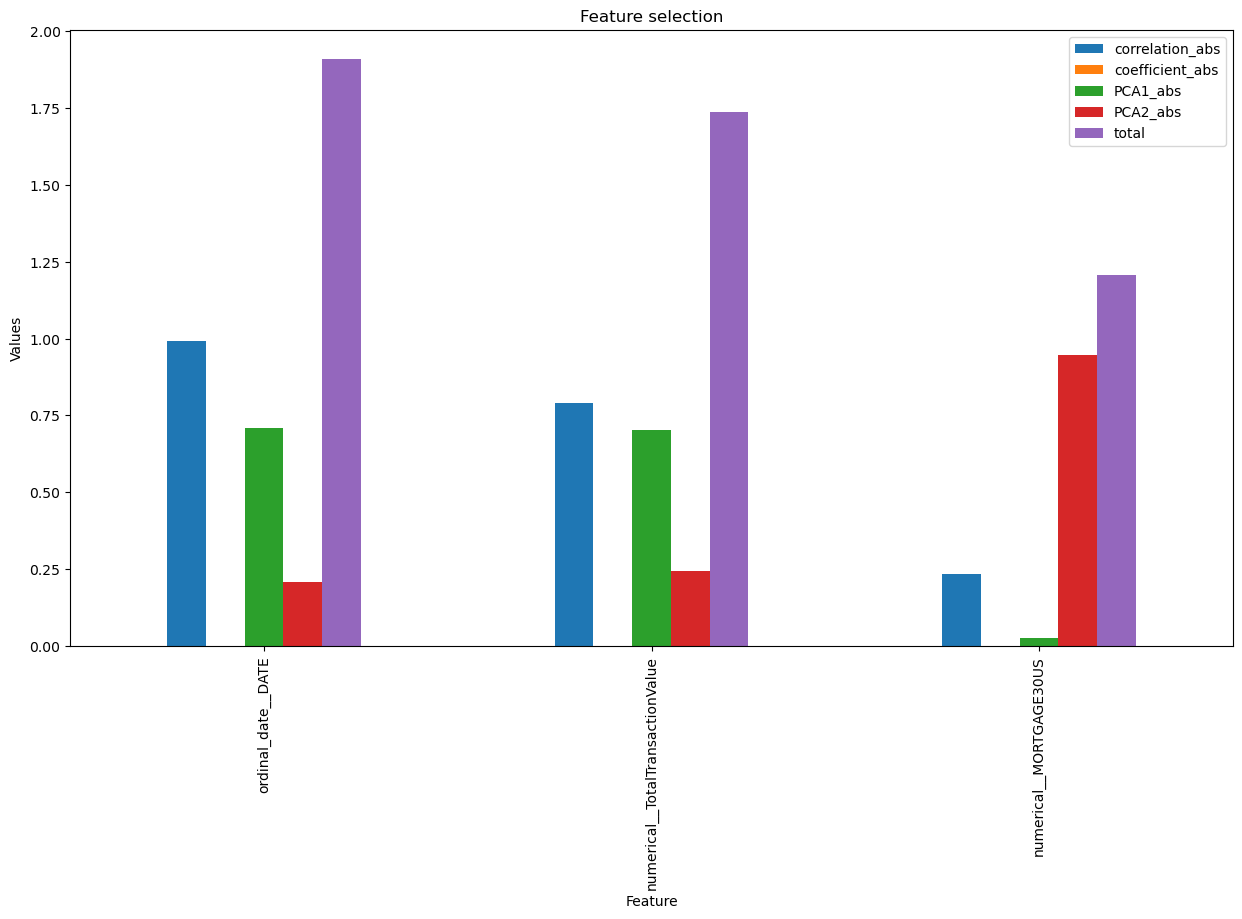

In [42]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [45]:
# Reload the data just to be safe
train_full_df = pd.read_csv(providence_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [46]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [47]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 3


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.994223,3.914544e-25,0.991362,0.990622,0.973694,0.016477,0.436885,"[0.5229080804072544, 0.5229080803956188, 0.522..."
Ridge Regression,0.982155,8.246290e-25,0.981804,0.980244,0.973694,0.016477,0.009757,"[0.5229080804079663, 0.5229080803949301, 0.522..."
LassoCV,0.982289,8.444995e-25,0.981366,0.979768,0.973694,0.016477,0.042091,"[0.522908080408, 0.5229080803947578, 0.5229080..."
ElasticNetCV,0.982289,8.444995e-25,0.981366,0.979768,0.973694,0.016477,0.039453,"[0.522908080408, 0.5229080803947578, 0.5229080..."
RidgeCV,0.982292,8.448237e-25,0.981358,0.979761,0.973694,0.016477,0.007736,"[0.5229080804080014, 0.522908080394767, 0.5229..."
Linear Regression,0.982292,8.451237e-25,0.981352,0.979753,0.973694,0.016477,0.012179,"[0.5229080804080019, 0.5229080803947653, 0.522..."


* Ridge CV has the highest r2 and adjusted r2 values and therefore the optimal choice

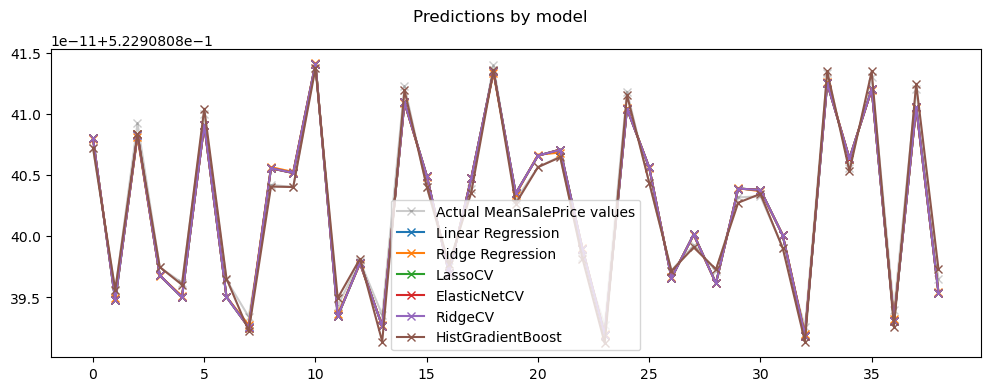

In [48]:
reg.plot_model_evaluations()

* Looks overfit to me

In [49]:
# Get the best model
reg.best_model_name

'HistGradientBoost'

## Now use the best model to predict on the test data

In [50]:
# Load test data from a different city
combined_file_path = '../../Data/Clean/combined/all_cities_combined.csv'
test_full_df = pd.read_csv(combined_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [51]:
# Drop target column
combined_file_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

KeyError: "['MeanSalePrice'] not found in axis"

In [52]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([196606.75008567, 199628.83459339, 201684.87637794, 200652.66189617,
       198613.30124795, 191729.23822738, 186125.99765161, 178196.75506636,
       174843.94760544, 162387.25676913, 157376.17426905, 151286.45251209,
       154622.31205013, 161655.94872807, 175672.67480683, 181653.12194711,
       184316.01967694, 179911.72165015, 177349.01277639, 176507.67475473,
       173205.05438723, 170792.17534001, 166887.89797862, 165365.84205734,
       172394.7619298 , 179050.96870049, 182533.90984736, 183421.51819959,
       180779.08279687, 174021.4286768 , 160208.97338809, 155303.5431149 ,
       156680.42756807, 160929.87133251, 155989.5661641 , 153274.0432015 ,
       151944.39977619, 158076.85378968, 169213.1825001 , 169999.75961204,
       163865.77279975, 149984.0913178 , 149339.59270538, 148063.75151315,
       147432.32723577, 146805.18017669, 145563.55956816, 146182.27068307,
       148699.49313454, 150633.03055772, 158782.51424193, 167657.30942395,
       166124.09416407, 1

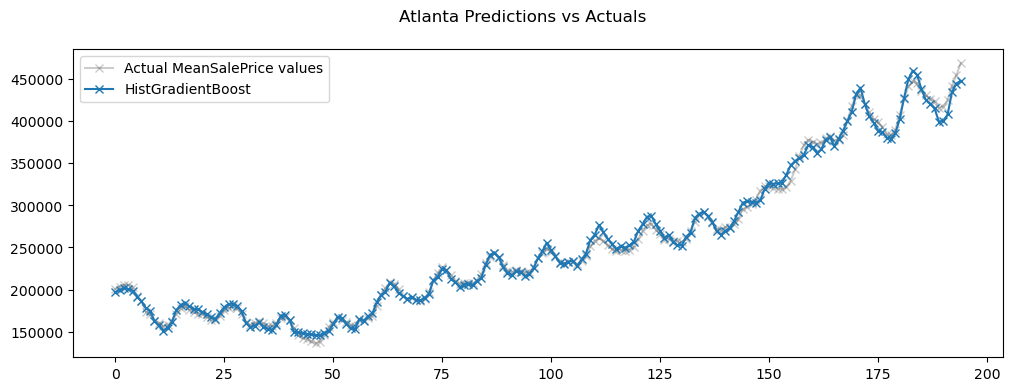

In [53]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()